In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

## Testing the Proportional Hazard Assumptions

This Jupyter notebook is a small tutorial on how to test and fix proportional hazard problems. Recall that the proportional hazard assumption is that the ratio of the hazard of the $i$th individual and the baseline hazard is constant (that is, not a function of time). 

In [30]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
cph = CoxPHFitter()

cph.fit(rossi, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [31]:
cph.print_summary(model="untransformed variables")

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-01-01 15:01:33 UTC
             model = untransformed variables


---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95   
fin  -0.38       0.68      0.19 -1.98   0.05   -3.05       -0.75       -0.00  .
age  -0.06       0.94      0.02 -2.61   0.01   -4.71       -0.10       -0.01  *
race  0.31       1.37      0.31  1.02   0.31   -1.18       -0.29        0.92   
wexp -0.15       0.86      0.21 -0.71   0.48   -0.73       -0.57        0.27   
mar  -0.43       0.65      0.38 -1.14   0.26   -1.36       -1.18        0.31   
paro -0.08       0.92      0.20 -0.43   0.66   -0.41       -0.47        0.30   
prio  0.09       1.10      0.03  3.19 <0.005   -6.57        0.04        0.15  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0

### Checking assumptions with `check_assumptions`

New to lifelines 0.16.0 is the `CoxPHFitter.check_assumptions` method. This method will compute statistics that check the proportional hazard assumption, produce plots to check assumptions, and more. Also included is an option to display advice to the console. Here's a breakdown of each information displayed:

 - Presented first are the results of a statistical test to test for any time-varying coefficients. A time-varying coefficient imply a covariate's influence _relative to the baseline_ changes over time. This implies a violation of the proportional hazard assumption. For each variable, we transform _time_ four times (these are common transformations of time to perform). If _lifelines_ rejects the null (that is, _lifelines_ rejects that the coefficient is not time-varying), we report this to the user.
 - Some advice is presented on how to correct the proportional hazard violation based on some summary statistics of the variable. 
 - As a compliment to the above statistical test, for each variable that violates the PH assumption, visual plots of the the _scaled Schoenfeld residuals_ is presented against the four time transformations. A fitted lowess is also presented, along with 10 bootstrapped lowess lines (as an approximation to the confidence interval of the original lowess line). Ideally, this lowess line is constant (flat). Deviations away from the constant line are violations of the PH assumption. 
 
####  Why the _scaled Schoenfeld residuals_?
 
This section can be skipped one first read. Let $s_{t,j}$ denote the scaled Schoenfeld residuals of variable $j$ at time $t$, $\hat{\beta_j}$ denote the maximum-likelihood estimate of the $j$th variable, and $\beta_j(t)$ a time-varying coefficient in (fictional) alternative model that allows for time-varying coefficients. Therneau and Grambsch showed that. 

$$E[s_{t,j}] + \hat{\beta_j} = \beta_j(t)$$

The proportional hazard assumption implies that $\hat{\beta_j} = \beta_j(t)$, hence $E[s_{t,j}] = 0$. This is what the above proportional hazard test is testing. Visually, plotting $s_{t,j}$ over time (or some transform of time), is a good way to see violations of $E[s_{t,j}] = 0$, along with the statisical test. 


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
               test_statistic      p  log(p)    
age  identity           12.06 <0.005   -7.57  **
     km                 11.03 <0.005   -7.02  **
     log                13.07 <0.005   -8.11  **
     rank               11.09 <0.005   -7.05  **
fin  identity            0.06   0.81   -0.21    
     km                  0.02   0.89   -0.12    
     log                 0.49   0.48   -0.73    
     rank                0.02   0.90   -0.11    
mar  identity            0.75   0.39   -0.95    
     km                  0.60   0.44   -0.82    
     log                 1.03   0.31   -1.17    
     rank                0.67   0.41   -0.88    
paro identity            0.12   0.73   -0.32    
     km                  0.12   0.73   -0.31    
     log                 0.01   0.92   -0.09    
     rank                0.14   0.71   -0.34    
prio identity            0.01

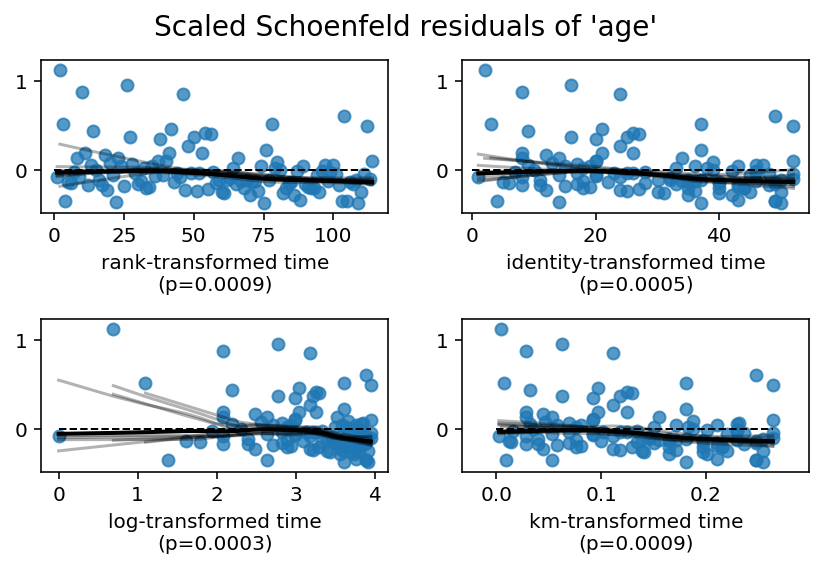

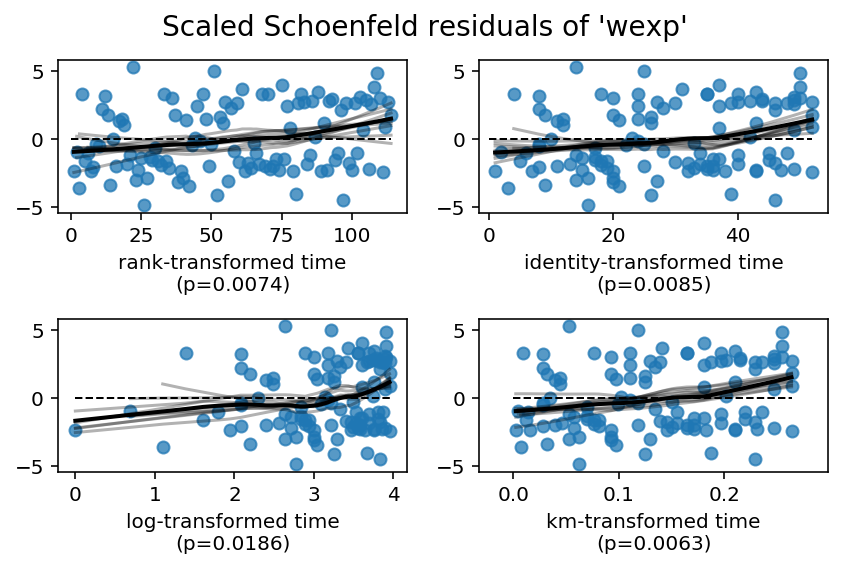

In [32]:
cph.check_assumptions(rossi)

Alternatively, you can use the proportional hazard test outside of `check_assumptions`:

In [33]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, rossi, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  log(p)    
age           11.094 0.001  -7.051  **
fin            0.017 0.896  -0.110    
mar            0.666 0.415  -0.881    
paro           0.138 0.711  -0.342    
prio           0.023 0.881  -0.127    
race           1.462 0.227  -1.484    
wexp           7.180 0.007  -4.910   *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


In the advice above, we can see that `wexp` has small cardinality, so we can easily fix that by specifying it in the `strata`. What does the `strata` do? For each unique value in the stratifying variable(s), a new baseline hazard is created. Hence, for each strata, a unique time-varying baseline can be created to fit the unique time-dependent effects of the variables. 

In [34]:
cph.fit(rossi, 'week', 'arrest', strata=['wexp'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -580.89
  time fit was run = 2019-01-01 15:01:45 UTC

---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95   
fin  -0.38       0.68      0.19 -1.99   0.05   -3.06       -0.76       -0.01  .
age  -0.06       0.94      0.02 -2.64   0.01   -4.79       -0.10       -0.01  *
race  0.31       1.36      0.31  1.00   0.32   -1.14       -0.30        0.91   
mar  -0.45       0.64      0.38 -1.19   0.23   -1.45       -1.20        0.29   
paro -0.08       0.92      0.20 -0.42   0.67   -0.40       -0.47        0.30   
prio  0.09       1.09      0.03  3.16 <0.005   -6.46        0.03        0.15  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.64
Likelihood ratio test = 188.99 on 6 df, log(p)=-86.07



<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
               test_statistic      p  log(p)    
age  identity           12.32 <0.005   -7.71  **
     km                 11.29 <0.005   -7.15  **
     log                13.29 <0.005   -8.23  **
     rank                4.62   0.03   -3.46   .
fin  identity            0.05   0.82   -0.20    
     km                  0.02   0.90   -0.11    
     log                 0.47   0.49   -0.70    
     rank                0.05   0.83   -0.19    
mar  identity            0.67   0.41   -0.89    
     km                  0.53   0.47   -0.76    
     log                 0.96   0.33   -1.12    
     rank                1.31   0.25   -1.38    
paro identity            0.10   0.75   -0.29    
     km                  0.09   0.76   -0.28    
     log                 0.02   0.90   -0.11    
     rank                0.00   0.97   -0.03    
prio identity            0.01

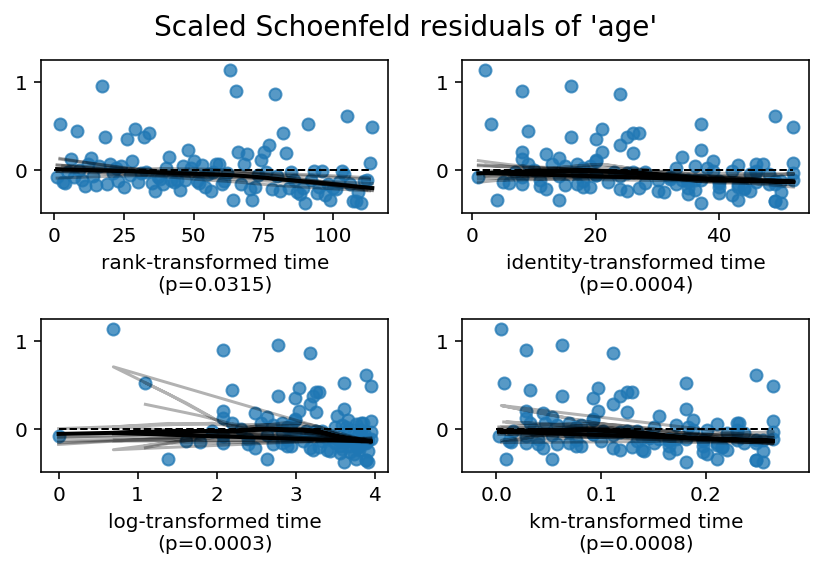

In [35]:
cph.check_assumptions(rossi)

Since `age` is still violating the proportional hazard assumption, we need to model it better.  From the residual plots above, we can see a the effect of age start to become negative over time. This will be relevant later. Below, we present two options to handle `age`. 

#### Option 1: bin variable and stratify on it

The first option proposed is to bin the variable into equal-sized bins, and stratify like we did with `wexp`. There is a trade off here between estimation and information-loss. If we have large bins, we will lose information (since different values are now binned together), but we need to estimate less new baseline hazards. On the other hand, with tiny bins, we allow the `age` data to have the most "wiggle room", but must compute many baseline hazards each of which has a smaller sample size. Like most things, the optimial value is somewhere inbetween.

In [36]:
rossi_strata_age = rossi.copy()
rossi_strata_age['age_strata'] = pd.cut(rossi_strata_age['age'], np.arange(0, 80, 3))

rossi_strata_age[['age', 'age_strata']].head()

,age,age_strata
0,27,"(24, 27]"
1,18,"(15, 18]"
2,19,"(18, 21]"
3,23,"(21, 24]"
4,19,"(18, 21]"


In [37]:
# drop the orignal, redundant, age column
rossi_strata_age = rossi_strata_age.drop('age', axis=1)
cph.fit(rossi_strata_age, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata', 'wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -392.443
  time fit was run = 2019-01-01 15:01:51 UTC
             model = stratified age and wexp


---
       coef  exp(coef)  se(coef)      z     p  log(p)  lower 0.95  upper 0.95   
fin  -0.395      0.674     0.197 -2.004 0.045  -3.100      -0.781      -0.009  .
race  0.280      1.324     0.313  0.895 0.371  -0.992      -0.334       0.895   
mar  -0.194      0.824     0.392 -0.494 0.621  -0.476      -0.961       0.574   
paro -0.163      0.849     0.200 -0.818 0.413  -0.884      -0.555       0.228   
prio  0.080      1.084     0.028  2.855 0.004  -5.447       0.025       0.135  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.640
Likelihood ratio test = 565.874 on 5 df, log(p)=-274.749


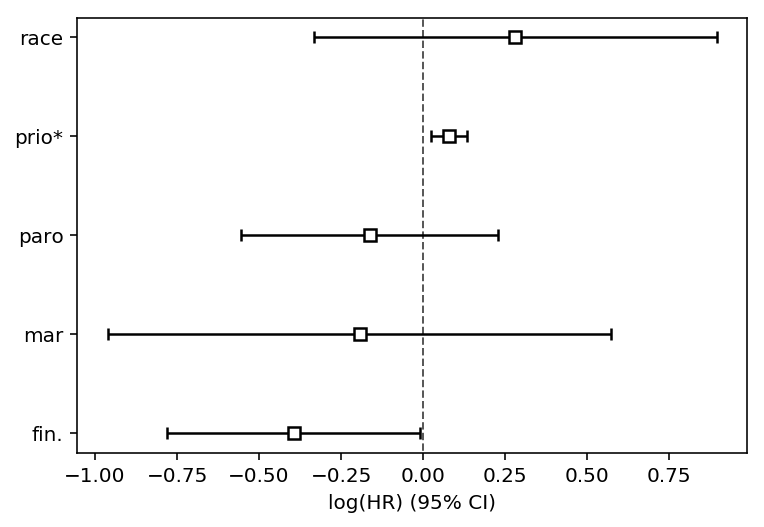

In [38]:
cph.print_summary(3, model="stratified age and wexp")
cph.plot()

In [39]:
cph.check_assumptions(rossi_strata_age)

Proportional hazard assumption looks okay.


#### Option 2: introduce time-varying covariates

Our second option to correct variables that violate the proportional hazard assumption is to model the time-varying component directly. This is done in two steps. The first is to transform your dataset into _episodic format_. This means that we split a subject from a single row into $n$ new rows, and each new row represents some time period for the subject. It's okay that the variables are static over this new time periods - we'll introduce some time-varying covariates later.

See below for how to do this in _lifelines_:

In [40]:
from lifelines.utils import to_episodic_format

# the time_gaps parameter specifies how large or small you want the periods to be. 
rossi_long = to_episodic_format(rossi, duration_col='week', event_col='arrest', time_gaps=1.)
rossi_long.head(25)


,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


Each subject is given a new id (but can be specified as well if already provided in the dataframe). This id is used to track subjects over time. Notice the `arrest` col is 0 for all periods prior to their (possible) event as well. 

Above I mentioned there were two steps to correct `age`. The first was to convert to a episodic format. The second is to create an interaction term between `age` and `stop`. This is a time-varying variable.

Instead of `CoxPHFitter`, we must use `CoxTimeVaryingFitter` instead since we are working with a episodic dataset. 

In [41]:
rossi_long['time*age'] = rossi_long['age'] * rossi_long['stop']

In [42]:
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

ctv.fit(rossi_long, 
        id_col='id', 
        event_col='arrest', 
        start_col='start', 
        stop_col='stop', 
        strata=['wexp'])

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>

In [43]:
ctv.print_summary(3)

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
 number of periods = 19809
  number of events = 114
    log-likelihood = -575.080
  time fit was run = 2019-01-01 15:01:56 UTC

---
           coef  exp(coef)  se(coef)      z     p  log(p)  lower 0.95  upper 0.95    
age       0.073      1.075     0.040  1.830 0.067  -2.698      -0.005       0.151    
fin      -0.386      0.680     0.191 -2.018 0.044  -3.133      -0.760      -0.011   .
mar      -0.397      0.672     0.382 -1.039 0.299  -1.208      -1.147       0.352    
paro     -0.098      0.907     0.196 -0.501 0.616  -0.484      -0.481       0.285    
prio      0.090      1.094     0.029  3.152 0.002  -6.424       0.034       0.146   *
race      0.295      1.343     0.308  0.955 0.340  -1.080      -0.310       0.899    
time*age -0.005      0.995     0.002 -3.337 0.001  -7.072      -0.008      -0.002  **
---
Signi

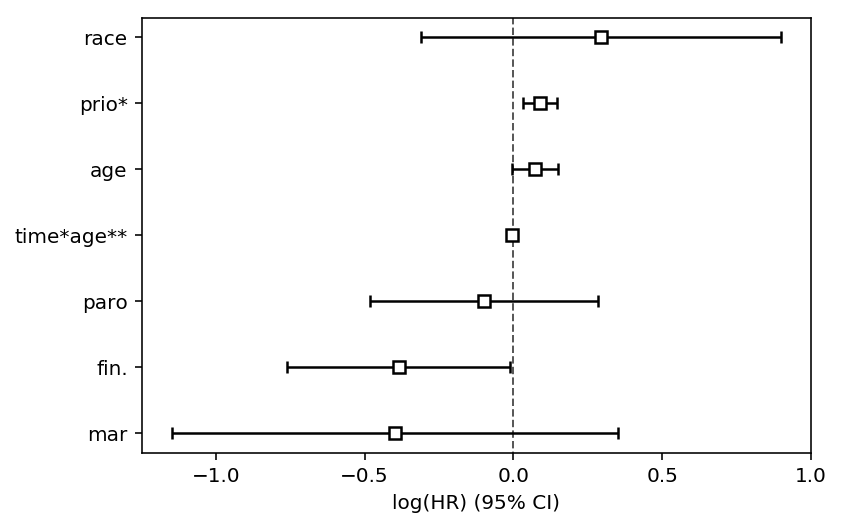

In [44]:
ctv.plot()

In the above scaled Schoenfeld residual plots for `age`, we can see there is a slight negative effect for higher time values. This is confirmed in the output of the `CoxTimeVaryingFitter`: we see that the coefficient for `time*age` is -0.005.

#### Conclusion

The point estimates and the standard errors are very close to each other using either option, we can feel confident that either approach is okay to proceed. 